### POS Tagging: Agenda
* <a href="#section1">What are parts of speech? Why are they useful?</a>
* <a href="#section2">How do you use them with SpaCy?</a>
* <a href="#section3">How do we infer them?</a>
* <a href="#section4"> How do we learn them with SpaCy?</a>


In [3]:
%run util/installers.ipynb



    Only loading the 'en' tokenizer.



util/installers.ipynb:23: UserWarning: Downloading Spacy Model
  "        import gensim\n",
util/installers.ipynb:29: UserWarning: Installing nltk
  "    nlp = spacy.load('en')\n",


Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda:

The following NEW packages will be INSTALLED:

    nltk: 3.2.4-py36_0 conda-forge

nltk-3.2.4-py3 100% |################################| Time: 0:00:00   2.40 MB/s


util/installers.ipynb:39: UserWarning: Installing keras
  "    try:\n",
util/installers.ipynb:45: UserWarning: Installing skater
  "        import keras\n",
util/installers.ipynb:48: UserWarning: You may need to refresh the notebook.
  "        !conda install keras -y >> ~/install.log\n",


In [1]:
import pandas as pd
import spacy
from spacy.matcher import Matcher
from spacy.attrs import POS
from spacy.en import English
import matplotlib.pyplot as plt
from functools import partial
import nltk
from operator import itemgetter
from itertools import groupby
from nltk.corpus import brown
from collections import defaultdict, Counter
import numpy as np
from spacy.tokens import Doc
from IPython.display import HTML
import warnings
import pandas as pd
from functools import wraps

def as_list(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        return list(f(*args, **kwargs))
    
    return wrapper
    


warnings.filterwarnings('ignore')
%matplotlib inline

map_ = as_list(map)
filter_ = as_list(filter)
zip_ = as_list(zip)

def rep_sentences(texts):
    html = []
    for text in texts:
        html.append(rep_sentence(text))
    return HTML("".join(html))

def rep_sentence(text, display_pos = True, words_to_highlight=[]):
    html_colors = ['SkyBlue'
               ,'red'
               ,'YellowGreen'
               ,'yellow'
               ,'orange'
               ,'pink'
               ,'brown'
               ,'purple'
               , 'CadetBlue'
                ,'DarkKhaki'
                ,'DarkSalmon'
                ,'Gold'    
              ]
    doc = nlp(text)
    n_words = len(doc)
    unique_pos = list(set(map(lambda x: x.pos_, doc)))
    pos_to_color = {i:html_colors[unique_pos.index(i)] for i in unique_pos}
    css = ["<style>.word{font-weight:bold;}</style>"]
    for pos in unique_pos:
        css.append('<style>.{}{{background-color:{};}}</style>'.format(*[pos, pos_to_color[pos]]))
    css = "".join(css)

    html = ["<table width=100%>"]
    html.append(css)
    html.append("<tr>")            
    for i in range(n_words):
        word_string= doc[i].orth_
        if word_string in words_to_highlight:
            word_string = "<u>{}</u>".format(word_string)
        html.append("<td><span class='word'>{0}</span></td>".format(word_string))
    html.append("</tr>")
    if display_pos:
        html.append("<tr>")            
        for i in range(n_words):
            pos = doc[i].pos_
            color = pos_to_color[pos]
            html.append("<td><span class='{0}'>{0}</span></td>".format(pos))
        html.append("</tr>")
    html = "".join(html)
    return html



def custom_tag_table(list_of_word_tag_tuples):
    html_colors = ['SkyBlue'
               ,'red'
               ,'YellowGreen'
               ,'yellow'
               ,'orange'
               ,'pink'
               ,'brown'
               ,'MediumPurple'
               , 'CadetBlue'
                ,'DarkKhaki'
                ,'DarkSalmon'
                ,'Gold'    
              ]
    
    n_words = len(list_of_word_tag_tuples)
    words, pos_list = zip(*list_of_word_tag_tuples)
    unique_pos = list(set([pos for pair in pos_list for pos in pair]))
    pos_to_color = {i:html_colors[unique_pos.index(i)] for i in unique_pos}
    css = ["<style>.word{font-weight:bold;}</style>"]
    for pos in unique_pos:
        css.append('<style>.{}{{background-color:{};}}</style>'.format(*[pos, pos_to_color[pos]]))
    css = "".join(css)

    html = ["<table width=100%>"]
    html.append(css)
    for i in range(n_words):
        html.append("<tr>")            
        word_string= words[i]
        html.append("<td><span class='word'>{0}</span></td>".format(word_string))
        row = []
        pos_sublist = pos_list[i]
        for pos in pos_sublist:
            entry = "<span class='{0}'>{0}</span> ".format(pos)
            #print entry
            row.append(entry)
        row = "".join(row)
        html.append("<td>{}</td>".format(row))
        html.append("</tr>")
    return "".join(html)
        
    

def nltk_corpus(corpus_name):
    corpus = getattr(nltk.corpus, corpus_name)
    try:
        corpus.ensure_loaded()
    except:
        nltk.download(corpus_name)
    return corpus

#read nltk corpora
def nltk_reader(corpus_name, limit = None):
    corpus = nltk_corpus(corpus_name)
    fileids = corpus.fileids()
    
    if limit:
        doc_iter = (" ".join([" ".join(j) for j in corpus.sents(fileid)]) for fileid in fileids[:limit])
    else:
        doc_iter = (" ".join([" ".join(j) for j in corpus.sents(fileid)]) for fileid in fileids)
    return doc_iter

universal_tags = [
     ['Open Class Words','ADJ','adjective', 'happy, great, technical']
    ,['Open Class Words','ADV','adverb', 'happily, greatly, technically']
    ,['Open Class Words','INTJ','interjection', 'ouch, wow']
    ,['Open Class Words','NOUN','noun', 'happiness, greatness, technicality']
    ,['Open Class Words','PROPN','proper noun', 'Jupyter, Lakers']
    ,['Open Class Words','VERB','verb', 'run, enlighten']
    ,['Closed Class Words','ADP','adposition', 'in, under, towards']
    ,['Closed Class Words','AUX','auxiliary', 'should [eat], had [been]']
    ,['Closed Class Words','CCONJ','coordination conjunction', 'and, or, but']
    ,['Closed Class Words','DET','determiner', 'the, a']
    ,['Closed Class Words','NUM','numeral', 'five, 5']
    ,['Closed Class Words','PART','particle', "'s, not"]
    ,['Closed Class Words','PRON','pronoun', 'him, she']
    ,['Closed Class Words','SCONJ','subordinating conjection', 'that, if']
    ,['Other','PUNCT','punctuation', "., ,"]
    ,['Other','SYM','symbol', "#, $"]
    ,['Other','X','other', "#2017, @JupyterCon"]
]
tag_table = pd.DataFrame(universal_tags, columns = ['Category','Abbrev','Part of Speech', 'Example'])
tag_table = tag_table.set_index(['Category','Abbrev'])

nltk.download('tagsets')
nltk.download('universal_tagset')
nlp = spacy.load('en')

[nltk_data] Downloading package tagsets to /home/jupyter/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


<a name="section1"></a>

### What are Parts of Speech?

<a name="universaltags"></a>

In [5]:
tag_table

Part of Speech  \
Category           Abbrev                             
Open Class Words   ADJ                    adjective   
                   ADV                       adverb   
                   INTJ                interjection   
                   NOUN                        noun   
                   PROPN                proper noun   
                   VERB                        verb   
Closed Class Words ADP                   adposition   
                   AUX                    auxiliary   
                   CCONJ   coordination conjunction   
                   DET                   determiner   
                   NUM                      numeral   
                   PART                    particle   
                   PRON                     pronoun   
                   SCONJ   subordinating conjection   
Other              PUNCT                punctuation   
                   SYM                       symbol   
                   X                          other   

                                                      Example  
Category           Abbrev                                      
Open Class Words   ADJ                happy, great, technical  
                   ADV          happily, greatly, technically  
                   INTJ                             ouch, wow  
                   NOUN    happiness, greatness, technicality  
                   PROPN                      Jupyter, Lakers  
                   VERB                        run, enlighten  
Closed Class Words ADP                     in, under, towards  
                   AUX               should [eat], had [been]  
                   CCONJ                         and, or, but  
                   DET                                 the, a  
                   NUM                                five, 5  
                   PART                               's, not  
                   PRON                              him, she  
                   SCONJ                             that, if  
Other              PUNCT                                 ., ,  
                   SYM                                   #, $  
                   X                       #2017, @JupyterCon

<a name='applications'></a>
### Applications
* Rule based systems:
    * information retrieval
    * <a href="#qacode">Example of rule based question answering component</a>
    
* Feature engineering for statistical models
    * Useful for language models (which in turn can be helpful for translation, etc...)
    * <a href="#wordsense">Feature for word disambiguation</a>
    * They often define syntactic requirements, so are helpful for parsers.

In [6]:
sentence1 = 'I get a discount on newspapers.'
sentence2 = 'I discount that newspaper.'

rep_sentences([sentence1, sentence2])

<a name="section2"></a>
### Parts of Speech with SpaCy
Lets see how we can access parts of speech with spacy:

In [7]:
### Accessing
doc = nlp('I get a discount on newspapers')

tags = {}

for word in doc:
    tags[word.orth_] = {'lemma': word.lemma_, 'pos (coarse)': word.pos_, 'pos (fine)':word.tag_}
    
pd.DataFrame(tags).T

,lemma,pos (coarse),pos (fine)
I,-PRON-,PRON,PRP
a,a,DET,DT
discount,discount,NOUN,NN
get,get,VERB,VBP
newspapers,newspaper,NOUN,NNS
on,on,ADP,IN


In [8]:
### Without POS tags, our word vectors arent disambiguating these...
discount1 = nlp('I get a discount on newspapers.')[3]
discount2 = nlp('I discount that newspaper.')[1]
discount1.similarity(discount2)

1.0000000338590165

### Homework: Building word vectors that are Part of Speech specific
Steps:
* get documents
* tokenize the documents, and append the part of speech to each token, e.g. dog||||NOUN
* train a word2vec model with gensim
* compare the most similar words of 'back||||VERB' vs 'back||||NOUN' (or other combo)

* Hints:
    * model.wv.vocab contains the vocabulary.
    * using a completely unique join character will make it easier to split later.

In [10]:
from gensim.models import Word2Vec

def return_documents():
    """
    Returns a list of documents, where each document is a string
    """
    from sklearn.datasets import fetch_20newsgroups
    dataset = fetch_20newsgroups()
    corpus = dataset.data
    return corpus

def tokenize_and_tag_documents(documents, nlp, sep_char="||||"):
    """
    Returns a list of lists of tokens. Each token has been 
    concatenated with its part of speech.
    
    Hint 1: nlp.pipe(documents) is faster than nlp(doc) for doc in documents
    Hint 2: Part of speech accessible via token.pos_
    Hint 3: iterating over a document yields tokens.
    """
    pass

def build_model(tokenized_docs):
    """
    Returns a gensim Word2Vec model trained on our corpus.
    Hint 1: use gensim.models.Word2Vec
    """
    pass

documents = return_documents()
tokenized_and_tagged_documents = tokenize_and_tag_documents(documents, nlp)
model = build_model(tokenized_and_tagged_documents)

if model:
    print(model.most_similar('real||||ADJ'))
    print()
    print(model.most_similar('real||||ADV'))

<a href="https://github.com/datascienceinc/jupytercon-2017/blob/master/tutorial/Solutions.ipynb#POS-1" id="solution1">Solution</a>


<script>

var url = window.location.href
var link = document.getElementById('solution1')
link.innerHTML = "Bye"
</script>

<a name="section3"></a>
### How do we infer parts of speech?
Take a moment to determine the parts of speech of the underlined words.
* e.g.: VERB, NOUN, PRON, PROPN, ADV

In [3]:
from IPython.display import clear_output, display
from ipywidgets import Button

class reveal(object):
    def __init__(self):
        self.text = 'I was loble to find the effix by klepping the Dongle search engine.'
        self.toggle = Button(description='Toggle POS', )
        self.toggle.on_click(self.toggle_pos)
        
        self.state = False
        display(self.toggle)
        self.display()
        
    def toggle_pos(self, b):
        self.state = not self.state
        self.display()
        
    def display(self):
        clear_output()
        #display(self.toggle)
        display(
            HTML(
                rep_sentence(
                    self.text, 
                    display_pos = self.state, 
                    words_to_highlight=['loble','effix', 'klepping','Dongle'])
            )
        )
        
# !jupyter nbextension enable --py widgetsnbextension --sys-prefix        
r = reveal()

I,was,loble,to,find,the,effix,by,klepping,the,Dongle,search,engine,.
PRON,VERB,ADJ,PART,VERB,DET,NOUN,ADP,VERB,DET,PROPN,NOUN,NOUN,PUNCT


### Determinants of Part of Speech:

| Feature | Notes | Example|
|------|------|------|
|   Word Identity  | Some words can only be used in a single way; we can memorize these.| "the" -> determiner| 
| Word Shape|Capitalization, dashes,  |"I stayed at the Park Hotel."|
|Neighboring parts of speech|There are common patterns what tags can neighbor others|"to the beach" (noun following determiner)|
|Morphological Structures|Word prefixes and suffixes can rule out certain tag types|"-ly" -> adverb|
|Syntactic Dependencies|Syntax may establish expectations that only certain tags can logically fill|"I was told __" -> adpositional phrase or object entity|
|?|?|?|


<a name="section4"></a>
### Homework: Training your own tagger with SpaCy

**Steps** : 
* load <a href="#load_data">**training data**</a>, where each observation is represented as (list_of_words, list_of_tags)
    * [('Darkness', 'fell', '.'), ('NN', 'VBD', '.')]


* Pick a <a href="#model_dir">**model directory**</a>. Using the existing English model will allow us to leverage lexeme information, including Brown clusters, which is an excellent feature for tagging.
    * nlp = spacy.load('en')
    * nlp.save_to_directory(modelpath)
    
    
* Look at your dataset. Build a <a href="#tagmap">**tag map**</a> mapping from the part of speech tags to the <a href="#universaltagset">universal tagset</a>.

    * tagmap = {'ADJ': {POS: 'ADJ'},'HASHTAG': {POS: "NOUN"}, ...}
    

* Decide which <a href="#featureextractors">**features**</a> to use
    * features = [ (W_shape,), (P1_pos,),(P1_suffix),(P2_pos,), (N1_pos,),(N1_suffix),(N2_pos,) ]
    * These ^^ are atomic predictors.
    * Atomic predictors can be combined, but there is no API to add new ones.
* create a <a href="#vocab">**vocabulary object, a statistical model, and a tagger**</a>

    * vocab = Vocab.load(modelpath, feature_extractors, lemmatizer, tagmap)
    * statistical_model = spacy.tagger.TaggerModel(features)
    * tagger = spacy.tagger.Tagger(vocab, statistical_model)


* <a href="#training">**Train the model**</a>
* <a href="#save">**Save the model**</a>

<a name="load_data"></a>

In [106]:
#load conll2000 corpus
from sklearn.model_selection import train_test_split
import nltk
def nltk_corpus(corpus_name):
    '''returns nltk corpus by name. if not loaded, download.'''
    corpus = getattr(nltk.corpus, corpus_name)
    try:
        corpus.ensure_loaded()
    except:
        nltk.download(corpus_name)
    return corpus


def clean(x):
    if x == '-LCB-':
        return '{'
    elif x=='-RCB-':
        return '}'
    elif x == '-RRB-':
        return ")"
    elif x == '-LRB-':
        return "("
    else:
        return x
    
def conll_to_data():
    corpus = nltk_corpus('conll2000')
    all_data= map_(lambda x: [(clean(i[0]), i[1]) for i in x], corpus.iob_sents())
    all_data = [zip_(*i) for i in all_data]
    return all_data

c2000 = conll_to_data()
training_data, testing_data = train_test_split(c2000, test_size = .1)

[nltk_data] Downloading package conll2000 to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.


<a href="#section4">Back</a>
<a name="model_dir"></a>

In [121]:
from pathlib import PosixPath
import os
home = os.path.expanduser('~')
modelpath = PosixPath('{}/mymodel'.format(home))
if not modelpath.exists():
    modelpath.mkdir()
    
nlp.save_to_directory(modelpath)

<a href="#section4">Back</a>
<a href="tagmap"></a>

In [122]:
from spacy.language_data import TAG_MAP
from spacy.attrs import POS
from spacy.symbols import PUNCT

def adjust_tagmap(tagmap):
    tagmap['('] = tagmap['-LRB-']
    tagmap[')'] = tagmap['-RRB-']
    tagmap['{'] = tagmap['-LRB-']
    tagmap['}'] = tagmap['-RRB-']
    tagmap['$'] = {POS: PUNCT}
    return tagmap

tagmap = adjust_tagmap(TAG_MAP)

<a href="#section4">Back</a>
<a name="featureextractors"></a>
### Features

* Example features: pos of previous word, identity of current word, etc...
* spacy.tagger.N1_cluster, spacy.tagger.N1_pos, etc...
* which word?
    * N1: Next
    * N0: Current
    * P1: Previous
    * etc...
* which attribute:
    * prefix
    * tag
    * cluster
    * etc...

In [126]:
from spacy.tagger import *


features = [
    #current word attributes
    (W_orth,),(W_shape,),(W_cluster,),(W_flags,),(W_suffix,),(W_prefix,),

    #-1 word attributes    
    (P1_pos,),(P1_cluster,),(P1_flags,),(P1_suffix,),

    #-2 word attributes     
    (P2_pos,),(P2_cluster,),(P2_flags,),

    #+1 word attributes    
    (N1_orth,),(N1_suffix,),(N1_cluster,),(N1_flags,),    

    #+2 word attributes    
    (N2_orth,),(N2_cluster,),(N2_flags,),

    #combination attributes
    (P1_lemma, P1_pos),(P2_lemma, P2_pos), (P1_pos, P2_pos),(P1_pos, W_orth)
]

<a href="#section4">Back</a>
<a name="vocab"></a>
### Vocabulary, Tagger, and Statistical Model
* The **Vocab** object will receive all the lexeme data (Brown clusters, word vectors, etc) from the English model.
* The **Statistical Model**  will consume the features we defined, using them to make predictions.
* The **Tagger** will consume our vocabulary object, and our statistical model.

In [127]:
nlp.Defaults.lex_attr_getters

{1: <function spacy.orth.is_alpha>,
 2: <function spacy.orth.is_ascii>,
 3: <function spacy.language.BaseDefaults.<lambda>>,
 4: <function spacy.orth.is_lower>,
 5: <function spacy.orth.is_punct>,
 6: <function spacy.language.BaseDefaults.<lambda>>,
 7: <function spacy.orth.is_title>,
 8: <function spacy.orth.is_upper>,
 9: <function spacy.orth.like_url>,
 10: <function spacy.orth.like_number>,
 11: <function spacy.orth.like_email>,
 12: <function spacy.language.BaseDefaults.<lambda>>,
 13: <function spacy.language.BaseDefaults.<lambda>>,
 14: <function spacy.orth.is_bracket>,
 15: <function spacy.orth.is_quote>,
 16: <function spacy.orth.is_left_punct>,
 17: <function spacy.orth.is_right_punct>,
 66: <function spacy.language.BaseDefaults.<lambda>>,
 67: <function spacy.language.BaseDefaults.<lambda>>,
 68: <function spacy.orth.word_shape>,
 69: <function spacy.language.BaseDefaults.<lambda>>,
 70: <function spacy.language.BaseDefaults.<lambda>>,
 72: <function spacy.language.BaseDefau

In [128]:
from spacy.vocab import Vocab

def get_lemmatizer():
    return None

def make_tagger(vocab, templates):
    model = spacy.tagger.TaggerModel(templates)
    return spacy.tagger.Tagger(vocab,model)

def get_feature_extractors(nlp):
    #return nlp.vocab.lex_attr_getters
    return nlp.Defaults.lex_attr_getters

#get requirements

feature_extractors = get_feature_extractors(nlp)
lemmatizer = get_lemmatizer()
vocab = Vocab.load(modelpath, feature_extractors, lemmatizer, tagmap)
statistical_model = spacy.tagger.TaggerModel(features)
tagger = spacy.tagger.Tagger(vocab, statistical_model)

In [129]:
# The untrained tagger is awful...
words = ['You','can','always','learn','more','by','reading']
doc = Doc(vocab, words = words)
tagger(doc)
map_(lambda x: (x.orth_, x.pos_), doc)

[('You', 'PUNCT'),
 ('can', 'PUNCT'),
 ('always', 'PUNCT'),
 ('learn', 'PUNCT'),
 ('more', 'PUNCT'),
 ('by', 'PUNCT'),
 ('reading', 'PUNCT')]

### Train the Model

In [130]:
#train
from spacy.scorer import Scorer
from spacy.gold import GoldParse

def predict_cycle(vocab, tagger, data, train=True):
    """For each document in data, creates a document and tags
    it. Creates a goldparse object to hold the ground truth label.
    If train=True, the tagger's statistical model is updated with the 
    result."""
    
    scorer = Scorer()
    
    for words, tags in data:
        #create a document, passing in words to become tokens
        doc = Doc(vocab, words = words)
        tagger(doc)
        gold = GoldParse(doc, tags=tags)   

        scorer.score(doc, gold)              
        
        if train:
            #train the model        
            tagger.update(doc, gold)
    return tagger, scorer

def train(vocab, tagger, training_data, testing_data, epochs = 10):
    """
    Parameters
    ----------
    tagger (spacy.tagger.Tagger): 
        The tagger to train.
        
    training_data (list):
        Training data containing words and annotated tags. 
        Should have form: [(word1, word2,...),(tag1, tag2, .....)]
        
    epochs (int):
        number of training iterations
        
    verbose (Bool):
        whether to track and print training accuracy
    """
    
    tagger, pre_train_scorer = predict_cycle(vocab, tagger, training_data, train=False)
    tagger, pre_test_scorer = predict_cycle(vocab, tagger, testing_data, train=False)
    
    print("Pre Training Accuracy: {0} Pre Test Accuracy {1}".format(pre_train_scorer.tags_acc, 
                                                                    pre_test_scorer.tags_acc))
    
    for train_cycle in range(epochs):
            
        tagger, _ = predict_cycle(vocab, tagger, training_data, train=True)
        
        
        tagger, train_scorer = predict_cycle(vocab, tagger, training_data, train=False)
        tagger, test_scorer = predict_cycle(vocab, tagger, testing_data, train=False)

        print("Iteration {0} Training Accuracy: {1} Test Accuracy {2}".format(train_cycle, 
                                                                              train_scorer.tags_acc, 
                                                                              test_scorer.tags_acc))
        #shuffle data    
        np.random.shuffle(training_data)
    
    tagger.model.end_training()
        
    return tagger

tagger = train(vocab, tagger, training_data, testing_data)

Pre Training Accuracy: 0.0 Pre Test Accuracy 0.0
Iteration 0 Training Accuracy: 95.78076064556761 Test Accuracy 94.80484103202708
Iteration 1 Training Accuracy: 97.5167839867699 Test Accuracy 96.08903763085185
Iteration 2 Training Accuracy: 98.71040714288775 Test Accuracy 97.19422500681013
Iteration 3 Training Accuracy: 98.69883936642859 Test Accuracy 97.09693738568704
Iteration 4 Training Accuracy: 99.11527931895787 Test Accuracy 97.32653617153754
Iteration 5 Training Accuracy: 99.43232208117152 Test Accuracy 97.5522434525431
Iteration 6 Training Accuracy: 99.01373994781648 Test Accuracy 97.15141845351597
Iteration 7 Training Accuracy: 99.50087186759609 Test Accuracy 97.47052185079971
Iteration 8 Training Accuracy: 99.42289648553813 Test Accuracy 97.40825777328092
Iteration 9 Training Accuracy: 99.7952075130566 Test Accuracy 97.8674553449819


### Try out the new tagger:

In [155]:
# The untrained tagger is awful...
words = ['You','can','always','learn','more','by','reading']
doc = Doc(vocab, words = words)
tagger(doc)
map_(lambda x: (x.orth_, x.pos_), doc)

[('You', 'PRON'),
 ('can', 'VERB'),
 ('always', 'ADV'),
 ('learn', 'VERB'),
 ('more', 'ADJ'),
 ('by', 'ADP'),
 ('reading', 'VERB')]

<a name="save"></a>
### Saving the Model

In [131]:
def save_tagger(tagger, model_dir):
    if model_dir is not None:
        tagger.model.dump(str(model_dir / 'pos' / 'model'))
        with (model_dir / 'vocab' / 'strings.json').open('w') as file_:
            tagger.vocab.strings.dump(file_)
            
save_tagger(tagger, modelpath)            

<a href="#section4">Back</a>
<a name="training"></a>
### More on Spacy's Statistical Model: Perceptron

##### Neuron Prediction:

**Inputs:** 

$<x_1, x_2, ..., x_n>$

**Each Neuron j:**

$prediction_j  = \bigg[\sum_{d=1}^D w_dx_{dj} \bigg] + b > 0$

##### Perceptron Learning:
```
For each training epoch:
    For each feature_vector, label:
        prediction = weights * feature_vector + bias

        if sign(label) != sign(prediction):
            weights = weights + (label*feature_vector)
            bias = bias + label
shuffle data
```

In [5]:
class PerceptronClassifier(object):
    def __init__(self):
        self.weights = None
        self.bias = None
        self.iter = 0

    def fit(self, X, y, epochs=100):
        """Fits self.weights, self.biases """
        self.initialize(X)
        
        for _ in range(epochs):
            for row, label in zip(X, y):
                prediction = self.predict(row)
                self.update(prediction, label, row)
                self.iter += 1
            X, y = shuffle(X, y) #important to reshuffle to avoid getting trapped
            
    def initialize(self, X):
        self.bias = 0
        self.weights = np.zeros(X.shape[1])#[:, np.newaxis]
                    
    def update(self, prediction, label, row):
        """Updates weights and biases based on the ground truth label
        and the row"""
        
        if prediction*label <= 0:
            update = label *  row            
            self.weights += update
            self.bias += label
        
    def predict_score(self, x):
        """Generates scores of "x". Uses self.weights and self.bias"""
        return np.dot(x, self.weights) + self.bias
    
    def predict(self, x):
        """ Converts prediction scores to 1s ands 0s."""
        predictions = np.where(self.predict_score(x) > 0, 1, -1)
        return predictions

<a href="https://github.com/datascienceinc/jupytercon-2017/blob/master/tutorial/Solutions.ipynb#POS-2">solution</a>

Lets see how it does on some sample data:

In [6]:
#generate some data
def generate_data(dim=1, N=1000):
    dim = 1
    true_b = np.random.normal(0, 2)
    X = np.random.normal(0, 10, size=(1000, dim))
    true_w = np.random.normal(0, 2, size=(dim,))
    err = np.random.normal(0, 10, size = N)
    labels = (np.dot(X, true_w) + err > true_b).astype(float)
    labels[np.where(labels==0)] = -1
    return X, labels, true_w, true_b

X, labels, true_w, true_b = generate_data()
b = PerceptronClassifier()
b.fit(X, labels, epochs=100)

acc_rate = (((b.predict(X) * labels) > 0).mean())
print("Training Accuracy Rate: {}".format(acc_rate))

Training Accuracy Rate: 0.655


True bias: -0.37
True weights: [ 0.10988004]
Current x: [ 5.00630542]
Current bias: 2.00
Current weights: [ 13.78474226]
Current Score: [ 5.00630542] * [ 13.78474226] + 2.0 = 71.01062994176876 > 0
Current Prediction: 1
Current True Label: -1
Error: True
Update EQS:
new_weights += (label*feature_vector)
Weights Update: += (-1 * [ 5.00630542]) = [-5.00630542]
new_bias += label
Bias Update: += -1



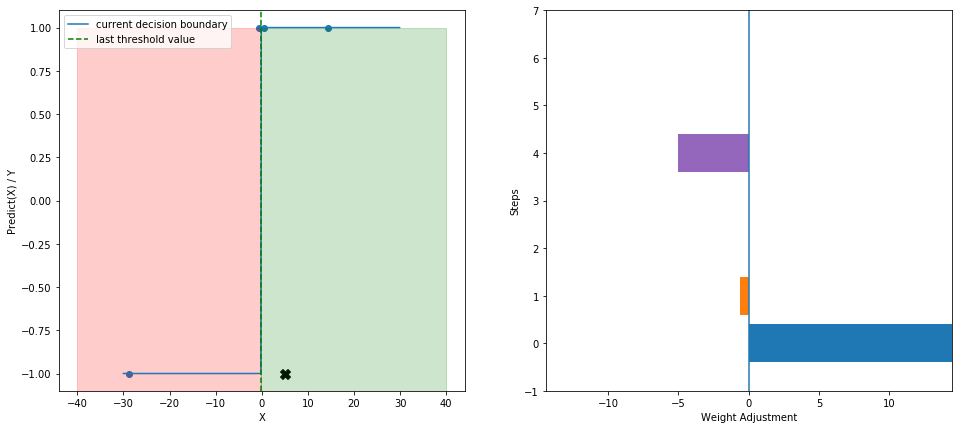

In [17]:
from ipywidgets import Button, Textarea
from IPython.display import clear_output, display

class PerceptronAnimator(object):
    def __init__(self, X, y, true_w, true_b):
        self.y_min = -1.1 
        self.y_max = 1.1        
        self.row_i = 0
        self.advance_button = Button(description="Advance")
        self.advance_button.on_click(self.advance)
        self.reverse_botton = Button(description="Reverse")
        self.reverse_botton.on_click(self.reverse)
        self.X = X
        self.y = y
        self.model = PerceptronClassifier
        display(self.advance_button)
        display(self.reverse_botton)
        self.true_b = true_b
        self.true_w = true_w
        self.thresholds = []
        self.errors = []
        self.advance(self.advance_button)

        
    def get_data(self, row_i):
        return self.X[:row_i], self.y[:row_i]
    
    def get_model(self, X, y):
        model = self.model()
        model.fit(X, y, epochs=1)
        return model
    
    def make_plots(self, ):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        ax1.set_ylim(self.y_min, self.y_max)
        ax1.set_xlabel("X")
        ax1.set_ylabel("Predict(X) / Y")
        ax2.set_ylabel("Steps")
        ax2.set_xlabel("Weight Adjustment")        
        return ax1, ax2
    
    def advance(self, b):
        ax1, ax2 = self.make_plots()
        next_x, next_y, ax1 = self.display_next(ax1)        
        threshold, error, ax1 = self.display_state(next_x, next_y, ax1)
        self.row_i += 1
        self.thresholds.append(threshold)
        self.display_thresholds(ax1)
        handles, labels = ax1.get_legend_handles_labels()
        ax1.legend(handles, labels)        
        self.errors.append(error)
        self.plot_errors(ax2)
        
    def reverse(self, b):
        ax1, ax2 = self.make_plots()
        if self.row_i > 0:
            self.row_i -= 1
            x, y, ax1 = self.display_next(ax1)            
            threshold, error, ax1 = self.display_state(x, y, ax1)
             
            self.thresholds = self.thresholds[:-1]
            self.display_thresholds(ax1)
            handles, labels = ax1.get_legend_handles_labels()
            ax1.legend(handles, labels)            
            self.errors = self.errors[:-1]
            self.plot_errors(ax2)
    def display_state(self, next_x, next_y, ax):
        clear_output()

        X, Y = self.get_data(self.row_i)
        model = self.get_model(X, Y)
        threshold = self.find_threshold(model)
        color_direction = self.pick_color_direction(model, threshold[-1])
        ax.scatter(X, Y)
        x_, y_ = self.make_line(ax, model)   
        ax.plot(x_, y_, label='current decision boundary')        

        error = self.update_text_box(model, next_x, next_y) 
        plt.legend()
        ax = self.shade_plot(threshold[-1], ax, color_direction)
        
        return threshold, error, ax

    def display_thresholds(self, ax):
        if len(self.thresholds) > 1:            
            ax.axvline(self.thresholds[-2], color='green', linestyle="--", label='last threshold value')              
    def plot_errors(self, ax):
        
        for i, err in enumerate(self.errors):
            ax.barh(i, err)
        largest_bar = max(max(self.errors), abs(min(self.errors)))
        ax.set_ylim(-1, len(self.errors) + 2)
        ax.set_xlim(min(-1, -1*largest_bar), max(1, largest_bar))
        ax.axvline(0)

    def display_next(self, ax):
        x, y = self.get_data(self.row_i +1)
        model = self.get_model(x[:-1], y[:-1])
        x, y = x[-1], y[-1]
        correct = int(y) == int(model.predict(x))

        #raise ValueError("")
        if correct:
            ax.scatter(x, y, color='black', s=100.)
        else:
            ax.scatter(x, y, color='black', s=100., marker = 'X')
        return x, y, ax
        

    
    def shade_plot(self, threshold, ax, color_direction):
        y = range(int(self.y_min - 1), int(self.y_max + 1))
        min_x = min(ax.get_xticks())
        max_x = max(ax.get_xticks())
        if color_direction: 
            ax.fill_betweenx(y, threshold, max_x, color='green', alpha=.2)
            ax.fill_betweenx(y, min_x, threshold, color='red', alpha=.2)
        else:
            ax.fill_betweenx(y, threshold, max_x, color='red', alpha=.2)
            ax.fill_betweenx(y, min_x, threshold, color='green', alpha=.2)            
        return ax
        
        
    def update_text_box(self, model, next_x, next_y):
        next_pred = model.predict(next_x)
        if next_pred == 0:
            next_pred = -1
        error = next_pred * next_y < 0
        update_b = next_y if error else 0
        update_w = next_y * next_x if error else 0
        msg = "True bias: {:.2f}".format(self.true_b)
        msg += "\n"
        msg +="True weights: {}".format(self.true_w)
        msg += "\n"              
        msg += "Current x: {}".format(next_x)
        msg += "\n"        
        msg += "Current bias: {:.2f}".format(model.bias)
        msg += "\n"
        msg +="Current weights: {}".format(model.weights) 
        msg += "\n"
        msg +="Current Score: {0} * {1} + {2} = {3} > 0".format(next_x, model.weights, model.bias, model.predict_score(next_x)) 
        msg += "\n"        
        msg += "Current Prediction: {}".format(next_pred)        
        msg += "\n"
        msg += "Current True Label: {}".format(int(next_y))        
        msg += "\n"        
        msg += "Error: {}".format(error)
        msg += "\n"
        if next_pred != int(next_y):
            msg += "Update EQS:"
            msg += "\n" 
            msg += "new_weights += (label*feature_vector)"
            msg += "\n"        
            msg += "Weights Update: += ({0} * {1}) = {2}".format(int(next_y), next_x, update_w)            
            msg += "\n" 
            msg += "new_bias += label"
            msg += "\n"             
            msg += "Bias Update: += {}".format(int(next_y))
            msg += "\n"        
        print(msg)
        return update_w
        
        
    def make_line(self, ax, model):
        x = [i / 10. for i in range(-300, 300)]
        y = np.array([(model.bias + i * model.weights[0]) > 0 for i in x]).astype(float)
        y[np.where(y==0)] = -1
        return x, y
    
    def find_threshold(self, model):
        x_range = np.array([i/10. for i in range(-300, 300)])[:, np.newaxis]
        y = abs(model.predict_score(x_range))
        
        idx = abs(y).argmin()
        return x_range[idx]
    
    def pick_color_direction(self, model, threshold):
        if model.predict(threshold + 1) > 0:
            return True
        else:
            return False
    
    
X, labels, true_w, true_b = generate_data()
p = PerceptronAnimator(X, labels, true_w, true_b)

What/how the model learns is sensitive to the ordering of the Xs. If X is multidimensional, and the last value is an outlier, our updates can be large, throwing the weights out of wack.

Solution: averaging the weights over an epoch, so that weights **that usually work, and thus stick around** are used.

##### Averaged Perceptron Learning:
```
list_of_weights, list_of_biases = list(), list()
For each training epoch:
    For each feature_vector, label:
        prediction = weights * feature_vector + bias

        if sign(label) != sign(prediction):
            weights = weights + (label*feature_vector)
            bias = bias + label
        add weights to list_of_weights
        add bias to list_of_biases
shuffle data
```

##### Averaged Perceptron Prediction:
```
weights = average(list_of_weights)
bias = average(list_of_bias)

prediction = weights * feature_vector + bias > 0
```



### Limitations of the Averaged Perceptron Model:
* Can only learn linear decision boundaries
* Can only use hardcoded representations
    * Solution: neural network.
    * Coming in SpaCy 2.0!

### Appendix

<a name='qacode'></a>
### Example Rule Based QA Component Code

In [5]:
def get_answer_requirements(token):
    if token.tag_ == 'WRB':
        if token.lower_ == 'where':
            #Where was Star Wars Filmed
            return ['LOCATION']
        elif token.lower_ == 'when':
            #When was Star Wars Filmed
            return ['DATE']
        elif token.lower_ == 'how':
            #How much did Star Wars make?
            if token.nbor().lower_ in ('much', 'many'):
                return ['QUANTITY']

            #How old is star wars?
            elif token.nbor().lower_ in ('long', 'old'):
                return ['DURATION']
            else:
                return False
        elif token.lower() == 'whom':
            #Whom did you see?
            return ['PERSON','ORG']      
        else:
            return False
    elif token.tag_ == 'WP':
        #Asking for Identity
        if token.lower_ in ('who', 'whose'):
            #Who directed Star Wars?
            return ['PERSON','ORG']
        if token.lower_ in ('which','what'):
            #What is Star Wars
            return False 
        else: 
            return False
    elif token.tag_ == 'WDT':
        #asking for a choice among options
        if token.lower_ in ('which','what'):
            #which Star Wars did you like best?
            return [token.nbor().lower_] #return neighbor
        else:
            return False
    else:
        return False

In [6]:
list(map(get_answer_requirements, nlp('Where was Star Wars filmed?')))

[['LOCATION'], False, False, False, False, False]

In [7]:
list(map(get_answer_requirements, nlp('Who directed Star Wars?')))

[['PERSON', 'ORG'], False, False, False, False]

In [10]:
list(map(get_answer_requirements, nlp('Which movie was first released?')))

[['movie'], False, False, False, False, False]

In [8]:
list(map(get_answer_requirements, nlp('In which country was Star Wars filmed?')))

[False, ['country'], False, False, False, False, False, False]

<a href='#applications'>back</a>
<a name="wordsense"></a>
##### Word sense disambiguation

In [131]:
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
for syn in wn.synsets('shower'):
    print(syn, syn.definition())

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Synset('shower.n.01') a plumbing fixture that sprays water over you
Synset('shower.n.02') washing yourself by standing upright under water sprayed from a nozzle
Synset('shower.n.03') a brief period of precipitation
Synset('shower.n.04') a sudden downpour (as of tears or sparks etc) likened to a rain shower
Synset('exhibitor.n.01') someone who organizes an exhibit for others to see
Synset('shower.n.06') a party of friends assembled to present gifts (usually of a specified kind) to a person
Synset('lavish.v.01') expend profusely; also used with abstract nouns
Synset('shower.v.02') spray or sprinkle with
Synset('shower.v.03') take a shower; wash one's body in the shower
Synset('shower.v.04') rain abundantly
Synset('shower.v.05') provide abundantly with


<a href='#applications'>back</a>